# T-TEDOPA: Finite Temperature Dynamics of the Spin-Boson Model

TODO: update text to reflect that this is the finite temperature example

We will now demonstrate how to use pyTTN to perform OQS dynamics for a spin-boson model using the T-TEDOPA method for finite temperature baths.  As for the zero temperature case, this requires only very minor changes from the finite temperature [Star Hamiltonian](files/../oqs_sbm_star_finite_T.ipynb) example


### Contents

1. [Import The Library](#importing-the-library)

2. [Setting up the Discrete Bosonic Bath](#setting-up-the-discrete-bosonic-bath)

3. [Setting up the System Information](#setting-up-the-system-information)

4. [Building the Hamiltonian](#building-the-hamiltonian)

5. [Building the Wavefunction](#building-the-wavefunction)

6. [Preparing for Time Evolution](#preparing-for-time-evolution)

7. [Performing the Time Evolution](#performing-the-time-evolution)

### Importing the Library

We start by importing the required modules.  This is unchanged from the [Star Hamiltonian](files/../oqs_sbm_star_finite_T.ipynb) example.

In [1]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn import oqs
from pyttn.utils import visualise_tree

### Setting up the Discrete Bosonic Bath

Next we define the spectral density of the bath and set up the `pyttn.oqs.BosonicBath` and `pyttn.oqs.DiscreteBosonicBath` objects.

 This is unchanged from the [Star Hamiltonian](files/../oqs_sbm_star_finite_T.ipynb) example.

In [2]:
#set up the time evolution information
dt = 0.05
tmax = 5
nstep = int(tmax/dt)+1
t = np.arange(nstep+1)*dt

#set up the bath spectral density
alpha = 1.0
s = 1
wc = 5

# Exponential cutoff spectral density
#@jit(nopython=True)
def J(w):
    return np.abs(np.pi/2*alpha*wc*np.power(w/wc, s)*np.exp(-np.abs(w/wc)))*np.where(w > 0, 1.0, -1.0)

#set up the BosonicBath
bath = oqs.BosonicBath(J, beta=1)

#maximum frequency cutoff upper bound in units of wc
Nw = 8

#discretise the bath using 256 modes 
Nb = 64
g, w = bath.discretise(oqs.OrthopolDiscretisation(Nb, bath.find_wmin(Nw*wc), Nw*wc))
discbath = oqs.DiscreteBosonicBath(g, w)


### Setting up the System Information

Now we get the system information from the `pyttn.oqs.DiscreteBosonicBath` object, optionally applying mode combination to combine primitive bosonic modes into composite modes.

 This is unchanged from the [Star Hamiltonian](files/../oqs_sbm_star_finite_T.ipynb) example.

In [3]:
#set up the total system information object including both system information and bath information
#here the system consists of a single two level system
sysinf = pyttn.system_modes(1)
sysinf[0] = pyttn.tls_mode()

nbose = 40
discbath.truncate_modes(pyttn.utils.EnergyTruncation(10*wc, Lmax=nbose, Lmin=4))

use_mode_combination = True
if use_mode_combination:
    #here we allow for the combination of up to four modes provided the resultant composite Hilbert space dimension has size less than 1000
    nbmax=4
    nhilbmax=1000
    mode_comb = pyttn.utils.ModeCombination(nbmax, nhilbmax)
    bsys = discbath.system_information(mode_comb)
else:
    bsys = discbath.system_information()

#now combine the system and bath information together
sysinf = pyttn.combine_systems(sysinf, bsys)


### Building the Hamiltonian

Here we see our first change compared to the example provided in [Star Hamiltonian](files/../oqs_sbm_star_finite_T.ipynb) example.  The T-TEDOPA method makes use of the chain geometry for the system-bath coupling Hamiltonian.  Within pyTTN, the geometry of the system-bath coupling Hamiltonian is controlled by the optional `geom` parameter.

To use the chain representation, we simply set this parameter to "chain".

In [4]:
#create the SOP object
H = pyttn.SOP(Nb+1)

#add on the system Hamiltonian
delta = 0.5
eps = 0
H += delta * pyttn.sOP("sx", 0) + eps * pyttn.sOP("sz", 0)

#and append all bath and system bath Hamiltonian terms
H = discbath.add_system_bath_hamiltonian(H, pyttn.sOP("sz", 0), geom="chain")

### Building the Wavefunction

We are now in a position to prepare the wavefunction tree topology.  This is where the second and final change from the [Star Hamiltonian](files/../oqs_sbm_star_finite_T.ipynb) example is made.  The T-TEDOPA method makes use of an MPS tree for representing the bath, this can be enforced by setting `degree=1`.


In [5]:
#bond dimension used at start of simulation
chi0 = 4

#maximum allowed bond dimension in network
chi = 64

#construct the MPS bath tree used for TEDOPA
degree = 1

#set up the topology tree
topo = pyttn.ntree("(1(2(2)))")
_ = discbath.add_bath_tree(topo(), degree, chi0, chi0)

#set up the capacity tree
capacity = pyttn.ntree("(1(2(2)))")
_ = discbath.add_bath_tree(capacity(), degree, chi, chi)


At this stage, the script proceeds identically to the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) example. 

In [6]:
#build the TTN object for this system
A = pyttn.ttn(topo, capacity, dtype=np.complex128)

#prepare a product state where the system is in the up spin state (0) and the bath is in its vacuum state
state = [0] + [0 for i in range(len(bsys))]
A.set_state(state) 

### Preparing for Time Evolution

In [7]:
#set up the Hamiltonian as a sop_operator object
h = pyttn.sop_operator(H, A, sysinf)

#set up the observable to measure
op = pyttn.site_operator(pyttn.sOP("sz", 0), sysinf)

#set up buffers to store the observable
Sz = np.zeros(nstep+1)

#construct matrix_element object need for evaluating observables
mel = pyttn.matrix_element(A)

#prepare the tdvp object
sweep = pyttn.tdvp(A, h, krylov_dim=12, subspace_neigs = 4, subspace_krylov_dim = 8, expansion='subspace')
sweep.spawning_threshold = 1e-8
sweep.minimum_unoccupied=0

sweep.dt = dt
sweep.coefficient = -1.0j

### Performing the Time Evolution

In [8]:
#measure the initial magnetisation
Sz[0] = np.real(mel(op, A, A))

#perform the first timestep using a logarithmic discretisation of time over this period.  
#This can be useful to allow for suitable adaptation of weakly occupied single particle 
#functions through the initial time point.
tp = 0
ts = np.logspace(np.log10(dt*1e-5), np.log10(dt), 5)
for i in range(5):
    dti = ts[i]-tp
    sweep.dt = dti
    sweep.step(A, h)
    tp = ts[i]

Now that we have completed the first step, we return to time evolution as usual.

In [ ]:
i=1
#set the values after the first timestep
Sz[i] =np.real(mel(op, A, A))
sweep.dt = dt

#now perform standard time stepping
for i in range(1,nstep):
    sweep.step(A, h)
    Sz[i+1] = np.real(mel(op, A, A))
    print("step: %d of %d.  Chimax: %d"%(i+1, nstep, A.maximum_bond_dimension()), end='                   \r')
print('                                                       \r')

And now that we have finished the time evolution we can plot the resultant magnetisation.

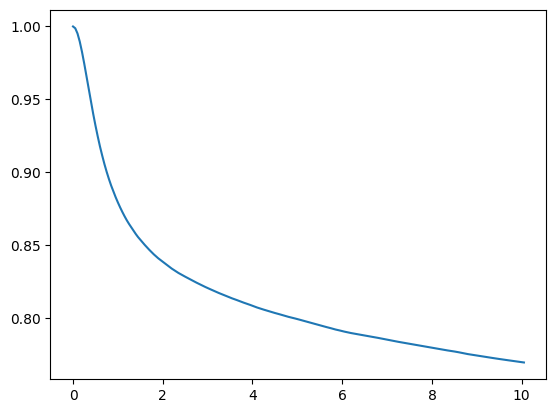

In [ ]:
plt.plot(t, Sz)
plt.show()

And we can also do things like visualise how the bond dimension has expanded throughout the tensor network.

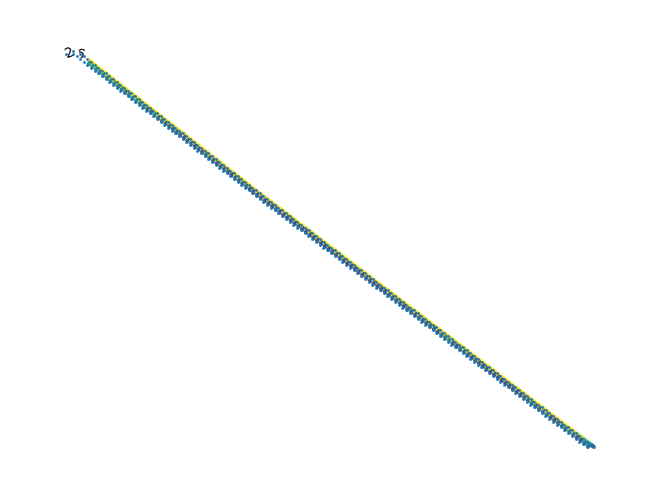

In [ ]:
visualise_tree(A, node_size=1, bond_prop="bond dimension")
plt.show()